# Earth Observation Data Scientist Assignment
# Gloria Storm(Januray 17th-25th, 2020)

In [1]:
# ! pip install geemap

In [2]:
# required libraries
import os
import ee
import geemap
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint



/Users/mimo/opt/anaconda3/envs/GeoData/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
# init Map
Map = geemap.Map()

In [4]:
# data paths
base_path = "/Users/mimo/Downloads/" # if you are saving data folders somewhere else, change this line and rest is same
spain_road_shape_file = os.path.join(base_path,"Spain-road/spain-road.shp")
Maresme_table_file    = os.path.join(base_path,"ESP_adm/ESP_adm3.shp")
Tordera_table_file    = os.path.join(base_path,"ESP_adm/ESP_adm4.shp")

In [5]:
# reading files 
Maresme_Table  = gpd.read_file(Maresme_table_file)
Tordera_Table  = gpd.read_file(Tordera_table_file)
SpainRoads     = gpd.read_file(spain_road_shape_file)


In [6]:
# filtering tables
Maresme = Maresme_Table[(Maresme_Table['NAME_2']=='Barcelona')&(Maresme_Table['NAME_3']=='n.a. (29)')].reset_index(drop=True)
Tordera = Tordera_Table[(Tordera_Table['NAME_2']=='Barcelona')&(Tordera_Table['NAME_3']=='n.a. (29)')&(Tordera_Table['NAME_4']=='Tordera')]
# Maresme_Roads = gpd.clip(SpainRoads, Maresme).reset_index(drop=True)
lines = SpainRoads.geometry.unary_union
intersection = lines.intersection(Maresme.geometry[0])
Maresme_Roads = gpd.GeoDataFrame({'geometry':intersection})


<AxesSubplot:>

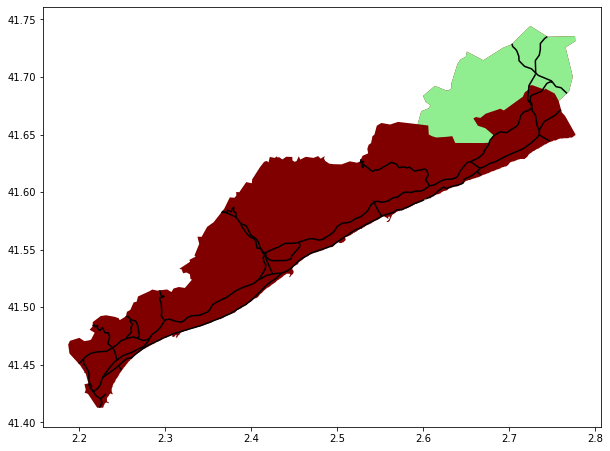

In [7]:
# visualize our area of interest
ax = Maresme_Roads.plot(figsize=(10,10), color='Black', edgecolor='gainsboro', zorder=3)
Maresme.plot(color='maroon', markersize=2, ax=ax)
Tordera.plot(color='lightgreen', ax=ax)


### geometry coordinates preparation for layer

In [8]:
# Helper function to convert geometry coordinates to list
def coord_lister(geom):
    coords = list(geom.exterior.coords)
    return (coords)
def linestring_to_points(line):
    return list(line.coords)

In [9]:
# polygon and line string to list of coordinates
Tordera_coordinates_list = list(Tordera.geometry.apply(coord_lister))
Maresme_coordinates_list = list(Maresme.geometry.apply(coord_lister))
Road_coordinates_list    = list(Maresme_Roads.geometry.apply(linestring_to_points))


In [10]:
# Prepare polygons for ROI
Maresme_Area = ee.Geometry.Polygon(Maresme_coordinates_list)
Tordera_Area = ee.Geometry.Polygon(Tordera_coordinates_list)
Maresme_Roads = ee.Geometry.MultiLineString(Road_coordinates_list)

# Flood Analysis

### Time Frame 

In [11]:
# reference normal surface
before_start = '2019-12-25'
before_end   ='2019-12-30'

# Formed	    17 January 2020
# Dissipated	25 January 2020
after_start  = '2020-01-17'
after_end    = '2020-01-26'

### SAR PARAMETERS

In [12]:
polarization = "VH"
pass_direction = "DESCENDING"
difference_threshold = 1.00

In [13]:
## Load and filter Sentinel-1 GRD data by predefined parameters 
collection= ee.ImageCollection('COPERNICUS/S1_GRD')\
  .filter(ee.Filter.eq('instrumentMode','IW'))\
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
  .filter(ee.Filter.eq('orbitProperties_pass',pass_direction))\
  .filter(ee.Filter.eq('resolution_meters',10))\
  .filterBounds(Maresme_Area)\
  .select(polarization)

In [14]:
# Select images by predefined dates
before_collection = collection.filterDate(before_start, before_end)
after_collection = collection.filterDate(after_start,after_end)

In [15]:
# Helper Function t0 Extract date from meta data
def dates(imgcol):
    range = imgcol.reduceColumns(ee.Reducer.minMax(), ["system:time_start"]);
    printed = ee.String('from ')\
        .cat(ee.Date(range.get('min')).format('YYYY-MM-dd'))\
        .cat(' to ')\
        .cat(ee.Date(range.get('max')).format('YYYY-MM-dd'))
    return printed


In [16]:
# Create a mosaic of selected tiles and clip to study area
before = before_collection.mosaic().clip(Maresme_Area)
after = after_collection.mosaic().clip(Maresme_Area)

In [17]:
# Apply reduce the radar speckle by smoothing  
smoothing_radius = 50
before_filtered = before.focal_mean(smoothing_radius, 'circle', 'meters')
after_filtered = after.focal_mean(smoothing_radius, 'circle', 'meters')

# FLOOD EXTENT CALCULATION

In [18]:
# Calculate the difference between the before and after images
difference = after_filtered.divide(before_filtered)

# Apply the predefined difference-threshold and create the flood extent mask 
threshold = difference_threshold
difference_binary = difference.gt(threshold)


In [19]:

# Loading JRC layer on surface water seasonality to mask flood pixels from areas
swater = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('seasonality')
swater_mask = swater.gte(10).updateMask(swater.gte(10))

#Flooded layer where perennial water bodies (water > 10 mo/yr) is assigned a 0 value
flooded_mask = difference_binary.where(swater_mask,0)
# final flooded area without pixels in perennial waterbodies
flooded = flooded_mask.updateMask(flooded_mask)

# Compute connectivity of pixels to eliminate those connected to 8 or fewer neighbours
# This operation reduces noise of the flood extent product 
connections = flooded.connectedPixelCount()    
flooded = flooded.updateMask(connections.gte(8))

# Mask out areas with more than 5 percent slope using a Digital Elevation Model 
DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
terrain = ee.Algorithms.Terrain(DEM)
slope = terrain.select('slope')
flooded = flooded.updateMask(slope.lt(5))

In [20]:
# Calculate flood extent area
flood_pixelarea = flooded.select(polarization).multiply(ee.Image.pixelArea())

In [21]:
# Sum the areas of flooded pixels
flood_stats = flood_pixelarea.reduceRegion(
  reducer    = ee.Reducer.sum(),              
  geometry   = Maresme_Area,
  scale      = 10, # native resolution 
  bestEffort = True
  )


In [22]:
# Converting the flood extent to hectares 
flood_area_ha = flood_stats\
  .getNumber(polarization)\
  .divide(10000)\
  .round()

# DAMAGE ASSESSMENT

### 1. Exposed population density

In [23]:
# Loading JRC Global Human Settlement Popluation Density dataset with Resolution: 250.
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015').clip(Maresme_Area);

In [24]:
# Calculate the amount of exposed population
# get GHSL projection
GHSLprojection = population_count.projection()

In [25]:
# Reproject flood layer to GHSL scale
flooded_res1 = flooded.reproject(crs= GHSLprojection);

In [26]:
# Create a raster showing exposed population only using the resampled flood layer
population_exposed = population_count.updateMask(flooded_res1).updateMask(population_count)

In [27]:
# Sum pixel values of exposed population raster 
stats = population_exposed.reduceRegion(
  reducer= ee.Reducer.sum(),
  geometry= Maresme_Area,
  scale= 250,
  maxPixels=1e9 )

In [28]:
# get number of exposed people as integer
number_pp_exposed = stats.getNumber('population_count').round()


### 2. Flood Effected Road

In [29]:
# flooded effected roads are those where we can see flood mask
# so we are masking only those part of road where we have flooded land
flooded_roads = flooded.clip(Maresme_Roads)


In [30]:
# Total road network length in Maresme County (length unity meter)
total_road_dist = Maresme_Roads.length()
total_road_dist = total_road_dist.getInfo()/1000

In [31]:
# Total flooded road network length in Maresme County 
flooded_roads_dist = flooded_roads.geometry().length()
total_flooded_road_dist = flooded_roads_dist.getInfo()/1000

### Add Layers

In [32]:
Map.centerObject(Maresme_Area,10)
Map.addLayer(before_filtered, {min:-25,max:0}, 'Before Flood',0)


In [33]:
Map.addLayer(Maresme_Area, {'color':'#d9dbda'}, 'Maresme County')
Map.addLayer(Tordera_Area,{'color':'#d4faf1'},"Tordera River Side Area")


In [34]:
Map.addLayer(after_filtered, {min:-25,max:0}, 'After Flood',0)
Map.addLayer(difference,{min:0,max:2},"Difference Layer",0)


In [35]:
Map.addLayer(flooded,{'palette':["0000FF"]},'Flooded areas')
## Population Density
populationCountVis = {
  'min': 0,
  'max': 200.0,
  'palette': ['060606','337663','337663','ffffff'],
}
Map.addLayer(population_count, populationCountVis, 'Population Density',0)

In [36]:
# Exposed Population
populationExposedVis = {
  'min': 0,
  'max': 200.0,
  "palette": ['#faee11'],
};
Map.addLayer(population_exposed, populationExposedVis, 'Affected Population');

In [37]:
# Roads
Map.addLayer(Maresme_Roads, {'color':"#11fa30"}, 'Roads')

In [38]:
Map.addLayer(flooded_roads, {"palette": ["#ff52f9"]}, 'Flooded Roads')

In [39]:
# add legend
legend_dict = {
    'Flooded Areas': '#0000FF',
    'Affected Population': '#faee11',
    'Roads': '#11fa30',
    'Flooded Roads': '#ff52f9',
  
}
Map.add_legend(legend_title="Gloria Storm Spain(17-01-2020-25-01-2020)", legend_dict=legend_dict)


In [40]:
Map

Map(center=[41.596668112799115, 2.5111105995968472], controls=(WidgetControl(options=['position', 'transparent…

In [41]:
print("Gloria Storm")
print("Formed	        17 January 2020")
print("Dissipated	25 January 2020")
print("-"*100)
print("#"*42+"   Statistics   "+"#"*42)
print("-"*100)
print(f"Total area of Maresme county: {round(Maresme_Area.area().getInfo()/10000,2)} He")
print(f"Total flooded area: {flood_area_ha.getInfo()} He")
print("."*100)
print(f"Total number of affected population: {number_pp_exposed.getInfo()}")
print("."*100)
print(f"Total road length: {total_road_dist} KM")
print(f"Total flooded road length: {total_flooded_road_dist} KM")

Gloria Storm
Formed	        17 January 2020
Dissipated	25 January 2020
----------------------------------------------------------------------------------------------------
##########################################   Statistics   ##########################################
----------------------------------------------------------------------------------------------------
Total area of Maresme county: 42879.46 He
Total flooded area: 824 He
....................................................................................................
Total number of affected population: 15912
....................................................................................................
Total road length: 196.57885012369243 KM
Total flooded road length: 196.57885012369397 KM


In [42]:
Map.to_html(outfile="map.html", title='My Map', width='100%', height='880px')